In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

from dateutil.parser import parse
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from datetime import datetime as dt
import numpy as np
import math
from sklearn import preprocessing

In [ ]:

df=pd.read_excel("Electricity-Demand-Time-Series-Analysis/DataSet/hourlyLoadDataIndia.xlsx")
print(df.head())
print(" ")

             datetime  National Hourly Demand  Northen Region Hourly Demand  \
0 2019-01-01 00:00:00               118690.67                      33692.02   
1 2019-01-01 01:00:00               116029.23                      32534.39   
2 2019-01-01 02:00:00               114044.14                      31730.37   
3 2019-01-01 03:00:00               113648.97                      31529.25   
4 2019-01-01 04:00:00               116290.05                      32406.61   

   Western Region Hourly Demand  Eastern Region Hourly Demand  \
0                      38522.22                      13128.89   
1                      38071.09                      12737.53   
2                      37680.10                      12387.36   
3                      37747.37                      12301.12   
4                      38101.80                      12479.13   

   Southern Region Hourly Demand  North-Eastern Region Hourly Demand  
0                       31681.83                             16

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')
df = df.set_index('datetime')
print(df.index.dtype)
print(df.index.min(), "→", df.index.max())


datetime64[ns]
2019-01-01 00:00:00 → 2024-04-30 23:00:00


In [ ]:
print(df.isna().sum())
target_col = 'National Hourly Demand'
print(f"Missing in {target_col}: {df[target_col].isna().sum()} rows")
df[target_col] = df[target_col].interpolate(method='time').fillna(method='ffill')


National Hourly Demand                0
Northen Region Hourly Demand          0
Western Region Hourly Demand          0
Eastern Region Hourly Demand          0
Southern Region Hourly Demand         0
North-Eastern Region Hourly Demand    0
dtype: int64
Missing in National Hourly Demand: 0 rows


/tmp/ipython-input-2278879022.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[target_col] = df[target_col].interpolate(method='time').fillna(method='ffill')


In [ ]:
df['hour'] = df.index.hour
df['weekday'] = df.index.weekday
df['month'] = df.index.month
df['year'] = df.index.year
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)

df.head()


,National Hourly Demand,Northen Region Hourly Demand,Western Region Hourly Demand,Eastern Region Hourly Demand,Southern Region Hourly Demand,North-Eastern Region Hourly Demand,hour,weekday,month,year,is_weekend
datetime,,,,,,,,,,,
2019-01-01 00:00:00,118690.67,33692.02,38522.22,13128.89,31681.83,1665.72,0,1,1,2019,0
2019-01-01 01:00:00,116029.23,32534.39,38071.09,12737.53,31129.97,1556.24,1,1,1,2019,0
2019-01-01 02:00:00,114044.14,31730.37,37680.10,12387.36,30760.87,1485.44,2,1,1,2019,0
2019-01-01 03:00:00,113648.97,31529.25,37747.37,12301.12,30616.27,1454.96,3,1,1,2019,0
2019-01-01 04:00:00,116290.05,32406.61,38101.80,12479.13,31839.38,1463.14,4,1,1,2019,0


In [ ]:
import numpy as np
import pandas as pd
cyc_features = pd.DataFrame({
    'hour_sin': np.sin(2 * np.pi * df['hour'] / 24),
    'hour_cos': np.cos(2 * np.pi * df['hour'] / 24),
    'month_sin': np.sin(2 * np.pi * (df['month'] - 1) / 12),
    'month_cos': np.cos(2 * np.pi * (df['month'] - 1) / 12)
})

print(cyc_features.head())


                     hour_sin  hour_cos  month_sin  month_cos
datetime                                                     
2019-01-01 00:00:00  0.000000  1.000000        0.0        1.0
2019-01-01 01:00:00  0.258819  0.965926        0.0        1.0
2019-01-01 02:00:00  0.500000  0.866025        0.0        1.0
2019-01-01 03:00:00  0.707107  0.707107        0.0        1.0
2019-01-01 04:00:00  0.866025  0.500000        0.0        1.0


In [ ]:
df['lag_1'] = df[target_col].shift(1)
df['lag_24'] = df[target_col].shift(24)
df['lag_168'] = df[target_col].shift(168)  # weekly lag

df['roll_3h_mean'] = df[target_col].rolling(3).mean()
df['roll_24h_mean'] = df[target_col].rolling(24).mean()
df['roll_168h_mean'] = df[target_col].rolling(168).mean()


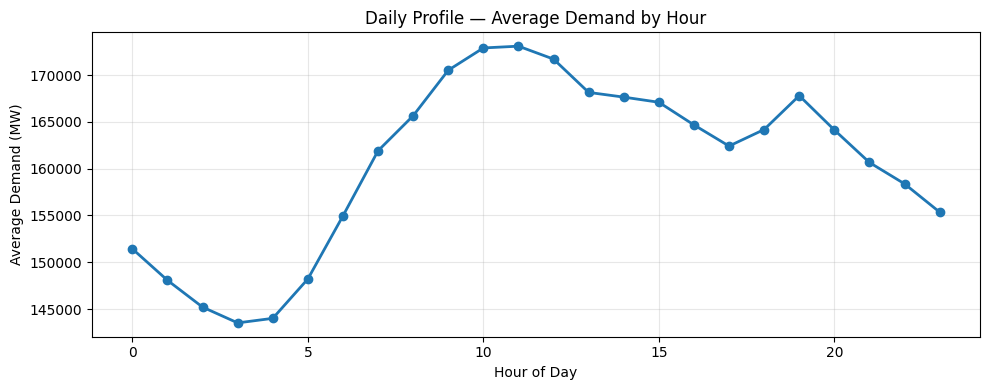

In [ ]:
import matplotlib.pyplot as plt

daily_profile = df.groupby('hour')[target_col].mean()

plt.figure(figsize=(10, 4))
plt.plot(daily_profile.index, daily_profile.values, marker='o', linewidth=2)
plt.title('Daily Profile — Average Demand by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Demand (MW)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


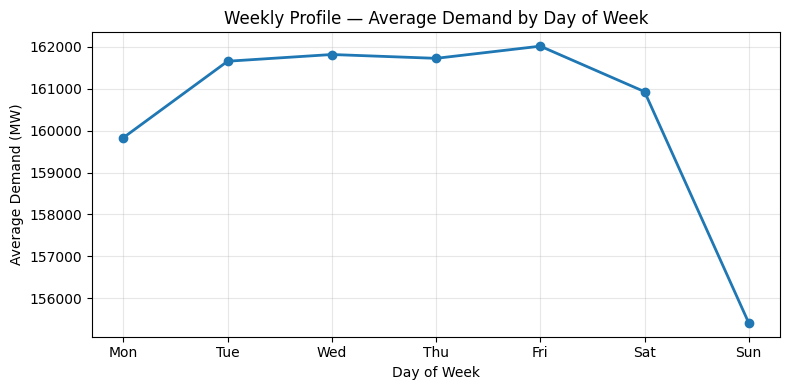

In [ ]:
weekly_profile = df.groupby('weekday')[target_col].mean()
weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.figure(figsize=(8, 4))
plt.plot(range(7), weekly_profile.values, marker='o', linewidth=2)
plt.xticks(range(7), weekday_labels)
plt.title('Weekly Profile — Average Demand by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Demand (MW)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


/tmp/ipython-input-3524018331.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df[target_col].resample('M').sum()


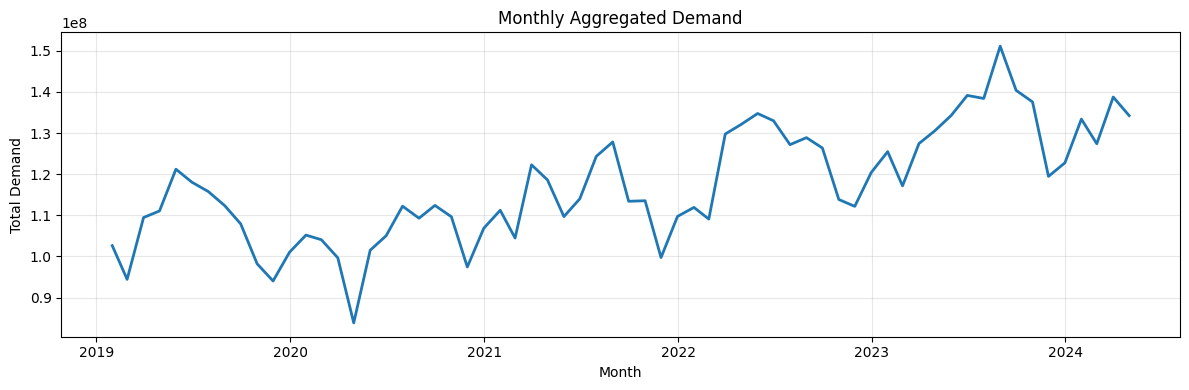

In [ ]:
monthly = df[target_col].resample('M').sum()

plt.figure(figsize=(12, 4))
plt.plot(monthly.index, monthly.values, linewidth=2)
plt.title('Monthly Aggregated Demand')
plt.xlabel('Month')
plt.ylabel('Total Demand')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
df_model = pd.concat([df, cyc_features], axis=1)
df_model['dayofweek'] = df_model.index.dayofweek
df_model = df_model[['National Hourly Demand',
                     'hour', 'dayofweek', 'month', 'lag_1',
                     'hour_sin', 'hour_cos', 'month_sin', 'month_cos']]


print(df_model.columns)


Index(['National Hourly Demand', 'hour', 'dayofweek', 'month', 'lag_1',
       'hour_sin', 'hour_cos', 'month_sin', 'month_cos'],
      dtype='object')


In [ ]:
X = df_model[['hour', 'dayofweek', 'month', 'lag_1',
              'hour_sin', 'hour_cos', 'month_sin', 'month_cos']]
y = df_model['National Hourly Demand']
print(X)
df_model['lag_1']=df_model['lag_1'].fillna(0)



                     hour  dayofweek  month      lag_1  hour_sin  hour_cos  \
datetime                                                                     
2019-01-01 00:00:00     0          1      1       0.00  0.000000  1.000000   
2019-01-01 01:00:00     1          1      1  118690.67  0.258819  0.965926   
2019-01-01 02:00:00     2          1      1  116029.23  0.500000  0.866025   
2019-01-01 03:00:00     3          1      1  114044.14  0.707107  0.707107   
2019-01-01 04:00:00     4          1      1  113648.97  0.866025  0.500000   
...                   ...        ...    ...        ...       ...       ...   
2024-04-30 19:00:00    19          1      4  194434.90 -0.965926  0.258819   
2024-04-30 20:00:00    20          1      4  201094.24 -0.866025  0.500000   
2024-04-30 21:00:00    21          1      4  196577.71 -0.707107  0.707107   
2024-04-30 22:00:00    22          1      4  194782.12 -0.500000  0.866025   
2024-04-30 23:00:00    23          1      4  194967.39 -0.258819

In [ ]:
split_index = int(len(df_model) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]


In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

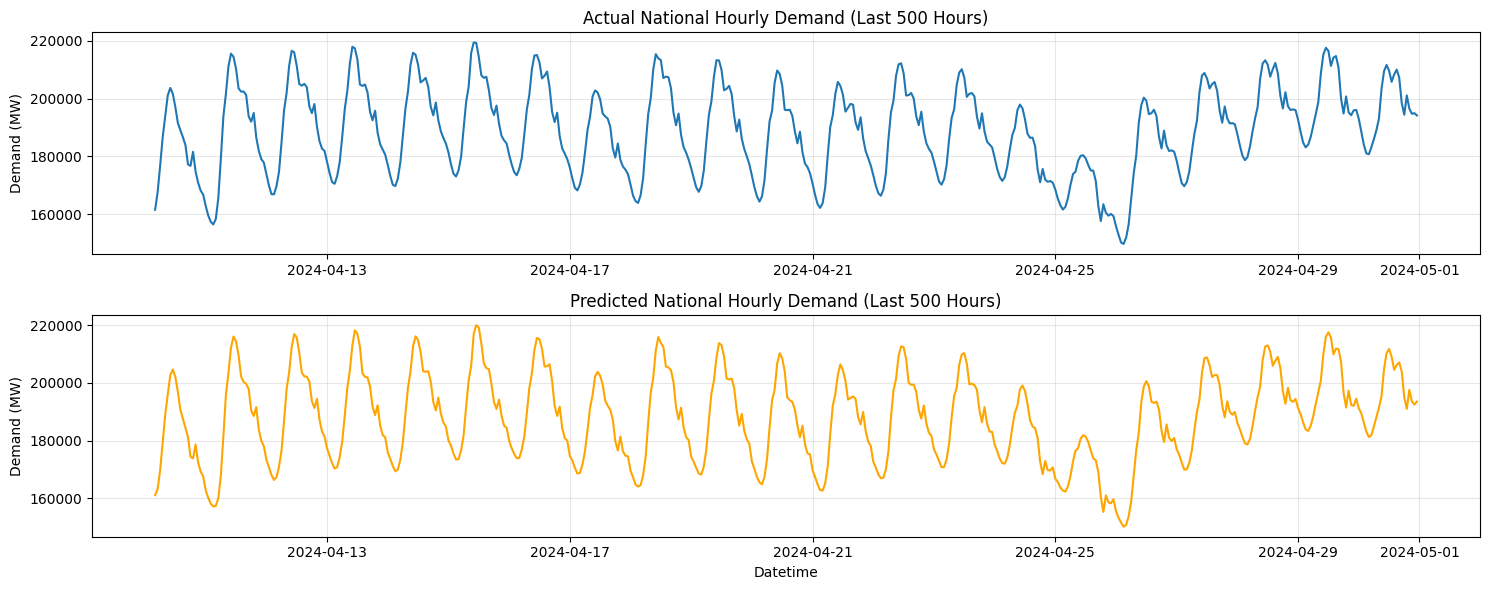

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

y_pred_series = pd.Series(y_pred, index=y_test.index)

n_points = 500
y_test_sample = y_test.tail(n_points)
y_pred_sample = y_pred_series.tail(n_points)

plt.figure(figsize=(15,6))

# --- Actual Demand Plot ---
plt.subplot(2, 1, 1)
plt.plot(y_test_sample.index, y_test_sample, color='tab:blue')
plt.title("Actual National Hourly Demand (Last 500 Hours)")
plt.ylabel("Demand (MW)")
plt.grid(alpha=0.3)

# --- Predicted Demand Plot ---
plt.subplot(2, 1, 2)
plt.plot(y_pred_sample.index, y_pred_sample, color='orange')
plt.title("Predicted National Hourly Demand (Last 500 Hours)")
plt.xlabel("Datetime")
plt.ylabel("Demand (MW)")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")
df_model['rolling_mean_3'] = df['National Hourly Demand'].rolling(window=3).mean().fillna(df['National Hourly Demand'])


RMSE: 3956.11


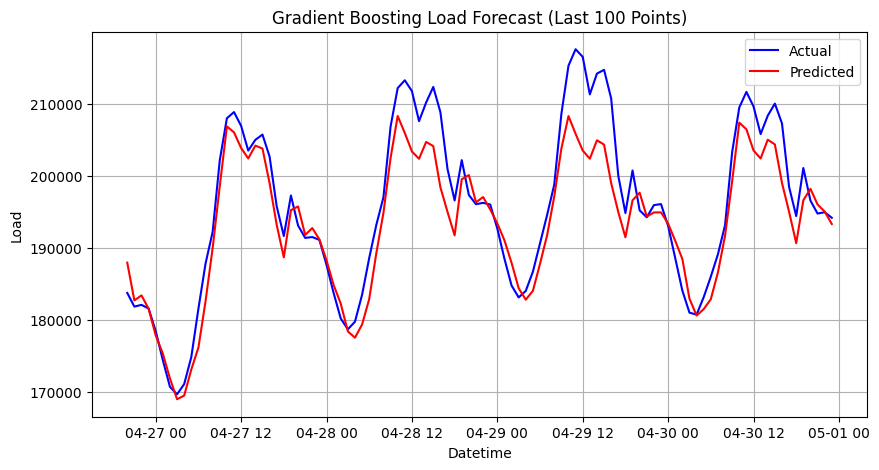

In [ ]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)
plt.figure(figsize=(10,5))
plt.plot(results[-100:].index, results['Actual'][-100:], label='Actual', color='blue')
plt.plot(results[-100:].index, results['Predicted'][-100:], label='Predicted', color='red')
plt.title('Gradient Boosting Load Forecast (Last 100 Points)')
plt.xlabel('Datetime')
plt.ylabel('Load')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
df_model['day'] = df_model.index.day
print(df_model.columns)


Index(['National Hourly Demand', 'hour', 'dayofweek', 'month', 'lag_1',
       'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'rolling_mean_3',
       'day'],
      dtype='object')


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.w

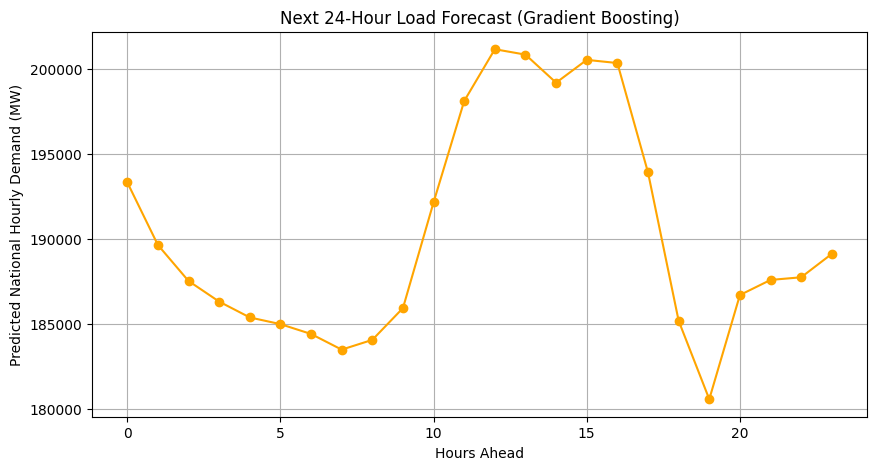

In [ ]:
last_row = df_model.iloc[-1].copy()

future_preds = []
for i in range(24):
    features = last_row[['hour', 'dayofweek', 'month', 'lag_1',
                         'hour_sin', 'hour_cos', 'month_sin', 'month_cos']].values.reshape(1, -1)

    next_load = gbr.predict(features)[0]
    future_preds.append(next_load)

    # Update lag and time features for the next step
    last_row['lag_1'] = next_load
    last_row['hour'] = (last_row['hour'] + 1) % 24
    if last_row['hour'] == 0:
        last_row['dayofweek'] = (last_row['dayofweek'] + 1) % 7
        last_row['month'] = (last_row['month'] % 12) + 1

    # Update cyclical time features
    last_row['hour_sin'] = np.sin(2 * np.pi * last_row['hour'] / 24)
    last_row['hour_cos'] = np.cos(2 * np.pi * last_row['hour'] / 24)
    last_row['month_sin'] = np.sin(2 * np.pi * (last_row['month'] - 1) / 12)
    last_row['month_cos'] = np.cos(2 * np.pi * (last_row['month'] - 1) / 12)


plt.figure(figsize=(10,5))
plt.plot(range(24), future_preds, marker='o', color='orange')
plt.title('Next 24-Hour Load Forecast (Gradient Boosting)')
plt.xlabel('Hours Ahead')
plt.ylabel('Predicted National Hourly Demand (MW)')
plt.grid(True)
plt.show()
